In [1]:
from math import sin,cos,pi,log,exp
import matplotlib.pyplot as plt
import numpy as np
import cfeplib

In [2]:
f=open('redtraj-4-0.rmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()

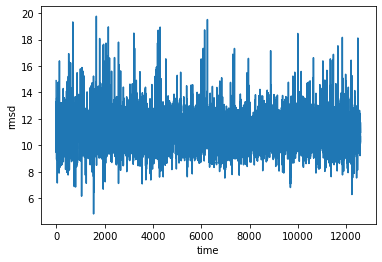

In [3]:
plt.plot(lrmsd[0:-1:100])
plt.xlabel('time')
_=plt.ylabel('rmsd')

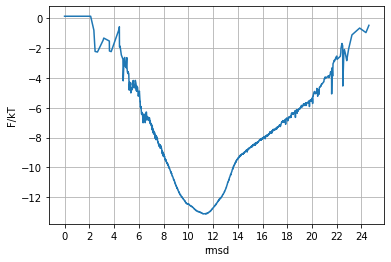

In [4]:
lx,lzh=cfeplib.comp_Zca(lrmsd,a=-1,dx=0.01,dt=1,strict=False)
lf=[-log(zh*2) for zh in lzh]

plt.plot(lx,lf)
plt.xticks(np.arange(0, 25, step=2))
plt.grid()
plt.xlabel('rmsd')
_=plt.ylabel('F/kT')


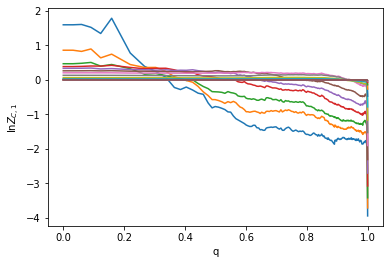

In [7]:
lq=cfeplib.to_committor(lrmsd,0.01,3,11)

ldt=[2**i for i in range(16)]
dx=0.001
for dt in ldt:
    ekn=cfeplib.comp_ekn_tp(lq,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=cfeplib.comp_Zca_ekn(ekn,a=1)
    plt.plot(lx,-np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [12]:
def Nab_traj(lrmsd,a,b):
    il=None
    n=0
    for x in lrmsd:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=3
b=11
lx1,ly1=cfeplib.comp_Zca(lrmsd,a=1,dx=0.0001)
print (Nab_traj(lrmsd,a,b),Nab_model(lx1,ly1,a,b))

1.0 0.6256289934324999


In [13]:
for dt in range(1,11):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

1 1.0 0.6256289934324999
2 1.0 1.8311762244789789
3 1.0 0.6228985689295774
4 1.0 2.139105744803059
5 1.0 1.6238909128503123
6 1.0 1.8697322941637944
7 0.0 0.8463607796445364
8 0.0 0.9566668290413842
9 0.0 0.7442638716442623
10 0.0 1.1543718677675525


In [14]:
for dt in range(10,40):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

10 0.0 1.1543718677675525
11 0.0 0.9839241483871534
12 1.0 2.858170548813465
13 0.0 1.0541608569579008
14 0.0 1.0612855117272006
15 1.0 1.8667438627677806
16 0.0 0.9716274618472112
17 1.0 1.8067504788782436
18 0.0 1.7989068937253976
19 1.0 5.029554425091434
20 0.0 1.1026823718002017
21 0.0 0.42143885270742903
22 0.0 0.6856233374704277
23 0.0 1.1687545698525594
24 0.0 1.1909520957723658
25 0.0 0.1138383598742782
26 0.0 0.6586247965616997
27 0.0 1.9191222579382234
28 0.0 1.4074932598212806
29 0.0 1.130426936287221
30 0.0 1.0496212277313344
31 0.0 1.9781329070287985
32 0.0 0.6932672484515057
33 0.0 1.021959150557476
34 0.0 1.4983952870815396
35 0.0 1.71760012522585
36 0.0 1.9004361357527528
37 0.0 2.0209870481994576
38 0.0 2.3859529018997496
39 0.0 0.5412437782720263


In [15]:
def fab_model(lrmsd,a,b,dx=0.001):
    lx,lzc1=cfeplib.comp_Zca(lrmsd,1,dx=dx)
    lx,lzh=cfeplib.comp_Zca(lrmsd,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(lrmsd)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(lrmsd,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(lrmsd):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
     
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(lrmsd,a,b))    
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(lrmsd,a,b))

model: NAB=0.576277, mfpt_AB=94.0993, mftp_BA=2.18492e+06, mtpt=79.4157
traj:  NAB=1, mfpt_AB=163, mftp_BA=154786, mtpt=104.5
